In [2]:
import sys
import logging
import itertools
import os
import pickle

In [3]:
import jax
import numpy as np
import jax.numpy as jnp
import numpy as onp
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import h5py
import jax.numpy as jnp
from functools import partial
import scipy.fft as fft
import fuzzylli.interpolation_jax as interpolate
from quadax import quadcc

In [4]:
# Visualisation stuff
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.patches import ConnectionPatch

import seaborn as sns

In [5]:
from jax.config import config
config.update("jax_enable_x64", True)
plt.style.use("./global_style.mplstyle")
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
columnwidth = 244.0/72.27
textwidth = 508.0/72.27

In [6]:
from fuzzylli.density import SteadyStateCylinder
from fuzzylli.units import set_schroedinger_units as set_units
from fuzzylli.potential import AxialSymmetricPotential, E_c, NonAxialSymmetricPotential
from fuzzylli.df import ConstantAnisotropyDistribution
from fuzzylli.domain import UniformHypercube
from fuzzylli.io_utils import load_or_compute_model, save_model, load_model, load_dict_from_group
from fuzzylli.eigenstates import init_eigenstate_library, eigenstate_library, eval_eigenstate
import fuzzylli.wavefunction as psi
from fuzzylli.interpolation_jax import interpolation_params
from fuzzylli.cosmology import h

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [7]:
from fdmfilaments.parameters_from_ellipsoidal_collapse import (
    cylinder_scale_radius_physical_Mpc, 
    cylinder_length_physical_Mpc, 
    cylinder_sqrt_v_dispersion_physical_kms
)

In [9]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):

    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

**Create these directories**

In [10]:
data_dir ="../data"
cache_dir ="../data/cache"
save_dir="../img"
save=False

## Load/Compute Wavefunction Parameters

In [10]:
seed = 42
N = 2**10
z = 4.0
a = 1./(1+z)

In [11]:
V = {}
rho = {}
df = {}
wavefunction_params = {}
eigenstate_lib = {}
units = {}

In [12]:
for m22, M_cylinder in itertools.product([1,2,4,8], [5e9]):
    units[m22] = set_units(m22)
    u = units[m22]
    Rmin = .1 * u.from_Kpc
    Rmax = 1 * u.from_Mpc
    units[m22] = u
    mu_cdm = 1e5 * u.from_Msun / (1*u.from_Mpc)
    
    df_params = {"R_min": 0.1 * u.from_Kpc, "epochs": 20000}

    for beta in [0.0, 0.5]:
        if beta==0.5 and m22>=4.0:
            continue
        tag = (M_cylinder,m22,beta)
        params_rho_steady_state = {
            "scalefactor": a,
            "r0": h**-1 * cylinder_scale_radius_physical_Mpc(M_cylinder, beta) * u.from_Mpc,
            "sigma2": (cylinder_sqrt_v_dispersion_physical_kms(M_cylinder, beta) * u.from_kms)**2,
        }
    
        params_rho_steady_state["beta"] = beta
        rho[tag] = SteadyStateCylinder(**params_rho_steady_state)
        source = lambda R: rho[tag](R)/a
        source.name = rho[tag].name
        V[tag] = AxialSymmetricPotential(source, rho[tag].R999)
        
        df[tag] = ConstantAnisotropyDistribution(params_rho_steady_state["beta"], a, V[tag], rho[tag], 
                                                       **df_params, R_max=rho[tag].R999)
        kwargs = {
            "for_name":[a,V[tag].name,V[tag](rho[tag].R99),N], 
            "for_compute":[a,V[tag],V[tag](rho[tag].R99),N]
        }
        name_lib, eigenstate_lib[tag] = load_or_compute_model(
                                        True,
                                        cache_dir,
                                        eigenstate_library.compute_name,
                                        init_eigenstate_library, 
                                        **kwargs)
        save_model(True, cache_dir, name_lib, eigenstate_lib[tag])

        init_routine = {
            "wkb":[psi.init_wavefunction_params_wkb, seed],
            "lasso":[psi.init_wavefunction_params_adaptive_lasso, seed],
            "poisson":[psi.init_wavefunction_params_poisson_process, mu_cdm, seed],
        }
        for routine in init_routine.keys():
            f = init_routine[routine][0]
            scalar_args = init_routine[routine][1:]
            kwargs = {
                "for_name":[routine, name_lib, rho[tag], rho[tag].R99, *scalar_args], 
                "for_compute":[eigenstate_lib[tag], rho[tag], df[tag], rho[tag].R99, *scalar_args]
            }
        
            name, wavefunction_params[tag + (routine, )] = load_or_compute_model(
                                                        True,
                                                        cache_dir,
                                                        psi.wavefunction_params.compute_name,
                                                        f,
                                                        **kwargs)
            save_model(True, cache_dir, name, wavefunction_params[tag + (routine, )])

INFO:fuzzylli.potential:dV/dR_max = 0.295
INFO:fuzzylli.potential:Rmin = 0.000, Rmax = 42.979
INFO:fuzzylli.potential:Using N = 250 interpolation points
INFO:fuzzylli.potential:Asymptotic exponenets of rho: alpha = -0.000, beta =3.991
INFO:fuzzylli.mlp:Initial loss: 4801.683307015786
INFO:fuzzylli.mlp:Final loss: 0.16144189795960023
INFO:fuzzylli.io_utils:Loading 140413999085790164...
INFO:fuzzylli.io_utils:Saving 140413999085790164...
INFO:fuzzylli.io_utils:Loading 540493773802658418...
INFO:fuzzylli.io_utils:Saving 540493773802658418...
INFO:fuzzylli.io_utils:Loading 513413248627586408...
INFO:fuzzylli.io_utils:Saving 513413248627586408...
INFO:fuzzylli.io_utils:Loading 216785440250545056...
INFO:fuzzylli.io_utils:Saving 216785440250545056...
INFO:fuzzylli.potential:dV/dR_max = 0.090
INFO:fuzzylli.potential:Rmin = 0.000, Rmax = 94.220
INFO:fuzzylli.potential:Using N = 434 interpolation points
INFO:fuzzylli.potential:Asymptotic exponenets of rho: alpha = -0.500, beta =3.495
INFO:fuzzy

## Figure 1

Figure 1 and Figure 2 will require a three dimensional box defined in `parameters/single_cylinder.yaml`. Please read this file to understand what parameters are required.
To generate the HDF5 file run:
```sh
$ ./populate_box.sh <NPROC> <HOSTFILE> parameters/single_cylinder.yaml
```
which is a simple wrapper around `fdmparameters/generate_density.py`
This will require MPI and a MPI-aware h5py, so make sure both are installed and functional. Installing this package via this pip may not be enough to achive this, depending on your environment.

Next, run:
```sh
$ ./render_box.sh <NPROC> <PATH_TO_HD5_FILE_PRODUCED_ABOVE>
```
to create a picture of the box.

In [15]:
def load_wavefunctions_params_from_hdf5(file):
    N = len(file["cylinders"])
    wavefunctions_params = []
    for i in range(N):
        raw_dict = load_dict_from_group(file, f"/cylinders/{i}/wavefunction_params/")
        R_j_params = raw_dict["eigenstate_library"]["R_j_params"]
        wavefunctions_params.append(
            psi.wavefunction_params(
                total_mass=raw_dict["total_mass"],
                R_fit=raw_dict["R_fit"],
                a_j=raw_dict["a_j"],
                phase_j=raw_dict["phase_j"],
                eigenstate_library=eigenstate_library(
                    E_j=raw_dict["eigenstate_library"]["E_j"],
                    l_of_j=raw_dict["eigenstate_library"]["l_of_j"],
                    n_of_j=raw_dict["eigenstate_library"]["n_of_j"],
                    R_j_params=interpolation_params(
                        a=R_j_params["a"],
                        dx=R_j_params["dx"],
                        f=R_j_params["f"],
                        lb=R_j_params["lb"],
                        ub=R_j_params["ub"],
                    ),
                ),
            )
        )
    return wavefunctions_params

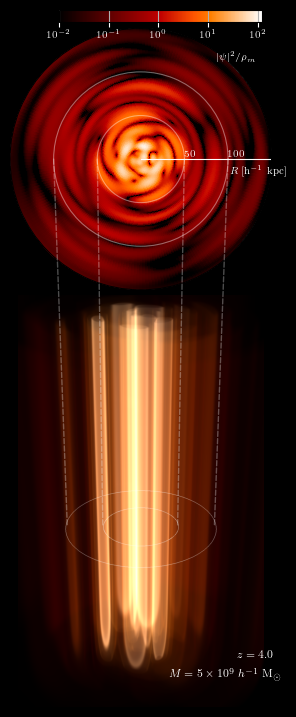

In [16]:
m22 = 2.0
z = 4
beta = 0
u = set_units(m22)

filename = f"{data_dir}/single_cylinder/single_cylinder_high_res.h5"

ax = []
ax = [plt.subplot(211, projection='polar'), plt.subplot(212)]
fig = plt.gcf()
fig.set_size_inches(columnwidth, 2.9*columnwidth)

Rmin = .1 * u.from_Kpc
Rmax = 150 * u.from_Kpc
R_phi_domain = UniformHypercube([250,250],np.array([[Rmin, 1.01 * Rmax],[0,2*np.pi]]))
Rphi = R_phi_domain.cell_centers_meshgrid
R, phi = R_phi_domain.cell_centers_cartesian[:,0], R_phi_domain.cell_centers_cartesian[:,1]
domain = R_phi_domain

t =[ 0 * u.from_Myr]
file = h5py.File(filename, "r")
wavefunction_showcase = load_wavefunctions_params_from_hdf5(file)[0]
file.close()
rho_psi = jax.vmap(lambda R, phi, t: jnp.abs(psi.psi(R, phi, t, wavefunction_showcase))**2, in_axes=(0,0,None))
rho_phiRt = rho_psi(R, phi, t[0]).reshape(domain.N)

fig.set_facecolor("black")

cmap = matplotlib.colormaps['gist_heat'].copy()
im = ax[0].pcolormesh(Rphi[1] - np.pi, Rphi[0] * u.to_Kpc * h, rho_phiRt, 
                   norm=colors.LogNorm(vmin=1e-2, vmax=120), cmap=cmap, rasterized=True)
cax = fig.add_axes([0.27, 0.81, 0.6, 0.012])
cb = fig.colorbar(im,orientation="horizontal",cax=cax)
cax.xaxis.set_label_position('bottom') 
cax.xaxis.tick_bottom()
cax.yaxis.label.set_color('white')
cax.tick_params(axis='x', colors='white')
ax[0].set_rlim(Rmin * u.to_Kpc *h, Rmax * u.to_Kpc*h)
rtick_loc = [50*h, 100*h]
ax[0].set_rticks(rtick_loc)
ax[0].set_yticklabels([r"$50$", r"$100$"])

#Phi direction
ax[0].set_xticklabels([])
ax[0].set_xticks([0.0], minor=False)

# R direction
ax[0].set_rlabel_position(0)
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='y', colors='white')

ax[0].grid(color="white")
ax[0].grid(axis="y", alpha=0.4)
ax[0].text(0.84, .44, r"$R\; \mathrm{[h^{-1}\;kpc]}$", transform=ax[0].transAxes, zorder=10, color="white")

cax.text(0.78, -3.3, r"$|\psi|^2/\rho_m$", color="white", transform=cax.transAxes)
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color="white")
cb.ax.yaxis.set_tick_params(color="white")

ax[1].grid(False)
ax[1].axis('off')
image = plt.imread(f"{save_dir}/volume_rendering_single_cylinder_high_res_0.png")
ax[1].imshow(image)
ax[1].text(1.07, 0.07, r"$M = 5\times10^{9}\;h^{-1}\;\mathrm{M_\odot}$", transform=ax[1].transAxes, zorder=10, ha="right", c="white", fontsize=8)
ax[1].text(1.04, 0.12, rf"$z = {z:.1f}$", transform=ax[1].transAxes, zorder=10, ha="right", c="white", fontsize=8)

kwargs = {"ls":"dashed", "alpha":0.30, "color":"white"}

con = ConnectionPatch(xyA=(0, 50*h), xyB=(.65,.44), coordsA="data", coordsB="axes fraction",
                      axesA=ax[0], axesB=ax[1], **kwargs)
ax[1].add_artist(con)
con = ConnectionPatch(xyA=(0, 100*h), xyB=(.80,.44), coordsA="data", coordsB="axes fraction",
                      axesA=ax[0], axesB=ax[1], **kwargs)
ax[1].add_artist(con)
con = ConnectionPatch(xyA=(np.pi, 50*h), xyB=(.345,.44), coordsA="data", coordsB="axes fraction",
                      axesA=ax[0], axesB=ax[1], **kwargs)
ax[1].add_artist(con)
con = ConnectionPatch(xyA=(np.pi, 100*h), xyB=(.20,.44), coordsA="data", coordsB="axes fraction",
                      axesA=ax[0], axesB=ax[1], **kwargs)
ax[1].add_artist(con)

fig.subplots_adjust(wspace=0.02, hspace=-0.17)
if not save:
    plt.show()
else:
    plt.savefig(f"{save_dir}/volume_rendering_crossection_beta_{beta:.1f}_z_{z:.1f}_m_{m22:.1f}.png", dpi=400, bbox_inches="tight", pad_inches=0.01)

## Figure 2

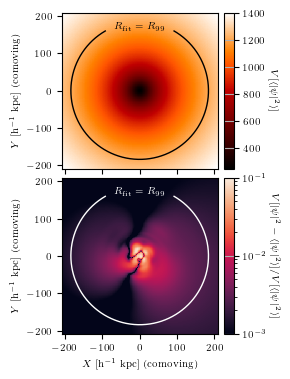

In [17]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

z = 4.0
beta = 0.0
m22 = 2.0
u = set_units(m22)
filename = f"{data_dir}/single_cylinder/single_cylinder_high_res.h5"

Rmin = .1 * u.from_Kpc
Rmax = 310 * u.from_Kpc
xy_domain = UniformHypercube([250,250],np.array([[-Rmax, Rmax],[-Rmax, Rmax]]))
xy = xy_domain.cell_centers_meshgrid
x, y = xy_domain.cell_centers_cartesian[:,0], xy_domain.cell_centers_cartesian[:,1]
R, phi = np.sqrt(x**2 + y**2), np.arctan2(y, x)

t =[ 0 * u.from_Myr]
file = h5py.File(filename, "r")
wavefunction_showcase = load_wavefunctions_params_from_hdf5(file)[0]
file.close()

rho_static = jax.vmap(lambda R : psi.rho(R, wavefunction_showcase))
rho_psi = jax.vmap(lambda R, phi: jnp.abs(psi.psi(R, phi, 0.0, wavefunction_showcase))**2, in_axes=(0,0))
rho_static_R = rho_static(R).reshape(xy_domain.N)
rho_psi_Rphi = rho_psi(R, phi).reshape(xy_domain.N)

V_nonaxial = NonAxialSymmetricPotential(xy_domain.dxi[0],xy_domain.N[0])
V_static_xy = V_nonaxial.solve(rho_static_R*(1+z),xy_domain.dxi[0])
V_int_xy = V_nonaxial.solve((rho_psi_Rphi-rho_static_R)*(1+z),xy_domain.dxi[0])

fig, ax = plt.subplots(nrows=2, sharex=True, subplot_kw=dict(box_aspect=1), figsize=(columnwidth, 2*0.618*columnwidth))

im0 = ax[0].pcolormesh(xy[0] * u.to_Kpc * h, xy[1] *u.to_Kpc* h, V_static_xy, cmap="gist_heat", rasterized=True)

ax0_divider = make_axes_locatable(ax[0])
cax0 = ax0_divider.append_axes("right", size="3%", pad="-25%")
cax0.set_label("Test")
cb0 = fig.colorbar(im0, cax=cax0)

im1 = ax[1].pcolormesh(xy[0] * u.to_Kpc * h, xy[1] *u.to_Kpc* h, np.abs(V_int_xy/V_static_xy),
                       norm=colors.LogNorm(vmin=1e-3, vmax=0.1),
                       cmap=sns.color_palette("rocket", as_cmap=True), rasterized=True)
ax1_divider = make_axes_locatable(ax[1])
cax1 = ax1_divider.append_axes("right", size="3%", pad="-25%")

cb1 = fig.colorbar(im1, cax=cax1)
cb0.set_label(r"$V[\langle|\psi|^2\rangle]$", rotation=270, labelpad=10)
cb1.set_label(r"$V[|\psi|^2 - \langle|\psi|^2\rangle]/V[\langle|\psi|^2\rangle]$", rotation=270, labelpad=10)
ax[0].grid(False)
ax[1].grid(False)

R_fit = wavefunction_showcase.R_fit
phi = np.linspace(0+np.pi/2+np.pi/6, 2*np.pi+np.pi/2-np.pi/6, 1000)
ax[0].plot(R_fit*np.cos(phi)* u.to_Kpc * h, R_fit*np.sin(phi)* u.to_Kpc * h, color="k", lw=1)
ax[1].plot(R_fit*np.cos(phi)* u.to_Kpc * h, R_fit*np.sin(phi)* u.to_Kpc * h, color="w", lw=1)

ax[0].text(0, R_fit* u.to_Kpc * h, r"$R_\mathrm{fit} = R_{99}$", ha="center", va="top")
ax[1].text(0, R_fit* u.to_Kpc * h, r"$R_\mathrm{fit} = R_{99}$", ha="center", va="top",c="w")
ax[0].set_ylabel(r"$Y\;\mathrm{[h^{-1}\; kpc]}\;\mathrm{(comoving)}$")
ax[1].set_ylabel(r"$Y\;\mathrm{[h^{-1}\; kpc]}\;\mathrm{(comoving)}$")
ax[1].set_xlabel(r"$X\;\mathrm{[h^{-1}\; kpc]}\;\mathrm{(comoving)}$")

fig.subplots_adjust(wspace=0.00, hspace=0.06)
if not save:
    plt.show()
else:
    plt.savefig(f"{save_dir}/potential_smoothing.pdf", format="PDF", dpi=300, bbox_inches="tight", pad_inches=0.01)

## Figure 3

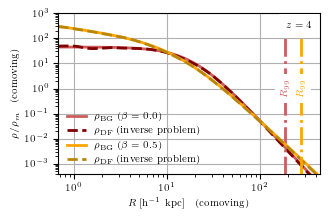

In [18]:
m22 = 2.0
u = units[m22]
betas = [0.0, 0.5]
M_cylinder = 5e9

x_min = 1 * u.from_Kpc
x_max = 650 * u.from_Kpc
R = np.logspace(np.log10(x_min), np.log10(x_max), 1000)

fig, ax = plt.subplots(figsize=(columnwidth,columnwidth * 0.618))
ax.set_xscale("log")
ax.set_yscale("log")

c = [("indianred","maroon"),("orange","darkgoldenrod")]
for beta, color in zip(betas, c):
    tag = (M_cylinder,m22,beta)
    rho_beta = rho[tag]
    df_beta = df[tag]

    light_c, dark_c = color
    line, = ax.plot(R *h * u.to_Kpc, rho_beta(R), label=rf"$\rho_\mathrm{{BG}} \;(\beta = {beta})$", c=light_c)
    ax.plot(R *h* u.to_Kpc, df_beta.rho(R), ls="dashed", c=dark_c, label=r"$\rho_\mathrm{DF}\; \mathrm{(inverse\;problem)}$")
    ax.axvline(x=rho_beta.R99 * h* u.to_Kpc, c=light_c, ls="-.")
    ax.text(rho_beta.R99 * h* u.to_Kpc,1, r'$R_{99}$',rotation=90, ha="center", va="center", color=light_c, 
            bbox=dict(facecolor='w', edgecolor="None"))
    ax.text(0.87,0.91, r"$z = 4$", 
            transform=ax.transAxes,
            bbox=dict(facecolor='w', edgecolor="None", pad=5))

ax.legend(*ax.get_legend_handles_labels())
ax.set_xlabel(r"$R\; \mathrm{[h^{-1}\;kpc]}\quad \mathrm{(comoving)}$")
ax.set_ylabel(r"$\rho/\rho_m \quad \mathrm{(comoving)}$")
ax.set_ylim([4e-4,1e3])
if not save:
    plt.show()
else:
    plt.savefig(f"{save_dir}/rho_BG_DF_z_{z:.1f}_m_{m22:.1f}.pdf", format="PDF", bbox_inches="tight", pad_inches=0.02)

## Figure 4

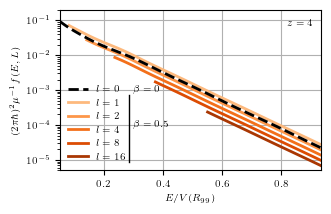

In [19]:
fig, ax = plt.subplots(figsize=(columnwidth,columnwidth * 0.618))
ax.set_yscale("log")
c = sns.color_palette("Oranges", 14)

m22 = 2.0
beta = 0.5
M_cylinder = 5e9
tag = (M_cylinder,m22,beta)
for i,l in enumerate([1,2,4,8,16]):
    Emin = max(E_c(psi.L(l),V[tag],a),eigenstate_lib[tag].E_j[0])
    E = np.linspace(Emin,1200, 100)
    df_EL = df[tag](E, psi.L(l)*np.ones_like(E)) * (2*np.pi)**2/rho[tag].total_mass
    ax.plot(E/V[tag](rho[tag].R99), df_EL, label=rf"$l={l}$", c=c[2*i+4])

m22 = 2.0
beta = 0.0
tag = (M_cylinder,m22,beta)
l = 0
Emin = max(E_c(psi.L(l),V[tag],a),eigenstate_lib[tag].E_j[0])
E = np.linspace(Emin,900, 100)
df_EL = df[tag](E, psi.L(l)*np.ones_like(E))* (2*np.pi)**2/rho[tag].total_mass
ax.plot(E/V[tag](rho[tag].R99), df_EL, label=rf"$l={l}$", c="k", ls="dashed")

ax.set_xlabel(r"$E/V(R_{99})$")
ax.set_ylabel(r'$(2\pi\hbar)^2 \mu^{-1}f(E,L)$')
handles, labels = plt.gca().get_legend_handles_labels()
order = [-1, 0,1,2,3,4]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="lower left")
ax.axvline(x=0.285,ymin=0.05, ymax=0.47, lw=1, c="k")
ax.text(0.3, 9e-5, r"$\beta = 0.5$")
ax.text(0.3, 9e-4, r"$\beta = 0$")
ax.text(0.87,0.9, r"$z = 4$", transform=ax.transAxes)
ax.set_ylim([5e-6, 0.2])
if not save:
    plt.show()
else:
    plt.savefig(f"{save_dir}/df_cut_z_{z:.1f}_m_{m22:.1f}.pdf", format="PDF",bbox_inches="tight", pad_inches=0.02)

## Figure 5

746


/tmp/ipykernel_2854889/2837381360.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(labels)
/tmp/ipykernel_2854889/2837381360.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(labels)
/tmp/ipykernel_2854889/2837381360.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(labels)
/tmp/ipykernel_2854889/2837381360.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(labels)
/tmp/ipykernel_2854889/2837381360.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(labels)
/tmp/ipykernel_

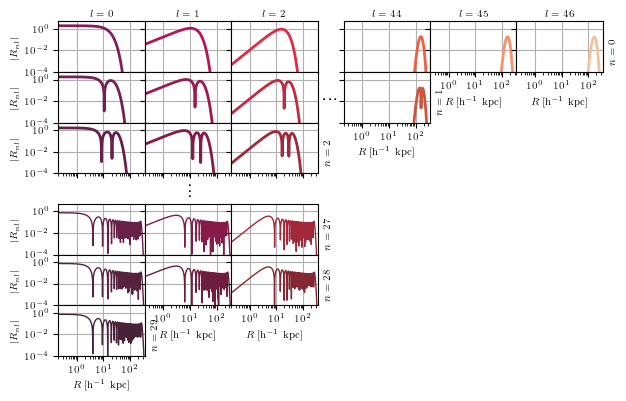

In [20]:
import matplotlib.gridspec as gridspec
evaluate = jax.vmap(jax.vmap(eval_eigenstate, in_axes=(0,None)), in_axes=(None, 0))

m22 = 2.0
beta=0.0
M_cylinder=5e9
tag = (M_cylinder,m22,beta)
u = units[m22]
lib = eigenstate_lib[tag]
print(lib.J)
cs = {}

base_color = sns.color_palette("rocket", 8)[2:]
colors = [sns.dark_palette(base, 6*6, reverse=True) for base in base_color]
for i, l in enumerate([0,1,2,44,45,46]):
    cs[l] = colors[i][::6]

Rmin = .2 * u.from_Kpc
Rmax = 350 * u.from_Kpc
R = np.logspace(np.log10(Rmin), np.log10(Rmax), 2000)
R_j_R = evaluate(R, lib.R_j_params)

fig = plt.figure(figsize=(textwidth,0.618*textwidth))

gs0 = gridspec.GridSpec(2, 2, figure=fig, wspace=0.1, hspace=0.2)

gs00 = gs0[0].subgridspec(3, 3, wspace=0.0, hspace=0.0)

ax = {}
for n in range(3):
    for l in range(3):
        j = lib.j_of_nl(n,l)
        ax[(n,l)] = fig.add_subplot(gs00[n, l])
        ax[(n,l)].plot(R * u.to_Kpc, np.abs(R_j_R[j,:]), c=cs[l][n])

gs01 = gs0[1].subgridspec(3, 3, wspace=0.0, hspace=0.0)

for n,ls in zip([0,1],[[44,45,46],[44]]):
    for l in ls:
        j = lib.j_of_nl(n,l)
        ax[(n,l)] = fig.add_subplot(gs01[n, l-44])
        ax[(n,l)].plot(R * u.to_Kpc, np.abs(R_j_R[j,:]), c=cs[l][n])

gs02 = gs0[2].subgridspec(3, 3, wspace=0.0, hspace=0.0)

for ns,l in zip([[27,28,29],[27,28],[27,28]],[0,1,2]):
    for n in ns:
        j = lib.j_of_nl(n,l)
        ax[(n,l)] = fig.add_subplot(gs02[n-27, l])
        ax[(n,l)].plot(R * u.to_Kpc, np.abs(R_j_R[j,:]), c=cs[l][(n-27+2)], lw=1)

for (n,l), a in ax.items():
    a.set_yscale("log")
    a.set_xscale("log")
    a.set_ylim([1e-4,5])
    if l>0:
        labels = a.get_yticklabels()
        for i in range(len(labels)):
            labels[i] = ""
        a.set_yticklabels(labels)
    if n==2 or n==27 or (n==0 and l<=44) or (n==1 and l<44) or (n==28 and l==0):
        labels = a.get_xticklabels()
        for i in range(len(labels)):
            labels[i] = ""
        a.set_xticklabels(labels)

for l in [0,1,2,44,45,46]:
    ax[(0,l)].text(0.5, 1.1, rf"$l={l}$", ha="center", transform=ax[(0,l)].transAxes)
for (n,l) in [(0,46),(1,44),(2,2),(27,2),(28,2),(29,0)]:
    ax[(n,l)].text(1.06, .4, rf"$n={n}$", va="center", transform=ax[(n,l)].transAxes, rotation=90)
for (n,l) in [(29,0),(28,1),(28,2),(1,44),(0,45),(0,46)]:
    ax[(n,l)].set_xlabel(r"$R\; \mathrm{[h^{-1}\;kpc]}$")
for n in [0,1,2,27,28,29]:
    ax[(n,0)].set_ylabel(r"$|R_{nl}|$")

ax[(27,1)].text(0.5, 1.25, rf"$\vdots$", fontsize=15,
                va="center", 
                transform=ax[(27,1)].transAxes)
ax[(1,2)].text(1.05, 0.5, rf"$\vdots$", fontsize=15,
                va="center", rotation=90,
                transform=ax[(1,2)].transAxes)
plt.savefig(f"{save_dir}/eigenstates_{beta:.1f}_z_{z:.1f}_m_{m22:.1f}.pdf", format="PDF", bbox_inches="tight", pad_inches=0.01)

## Figure 6

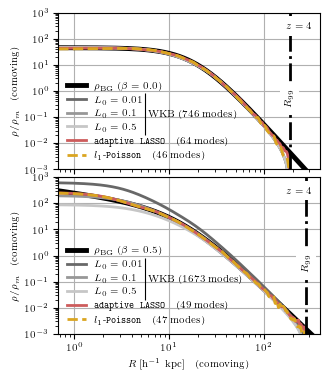

In [21]:
m22 = 2.0
u = units[m22]
M_cylinder=5e9

Rmin = 1 * u.from_Kpc
Rmax = 500 * u.from_Kpc
R = np.logspace(np.log10(Rmin), np.log10(Rmax), 1000)

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(columnwidth,2 * columnwidth * 0.618))

for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim([1e-3,2000])
    
rho_psi = jax.vmap(psi.rho, in_axes=(0,None))
def L_test(l, ll):
    return np.where(l > 0, l, ll)

blues = sns.color_palette("Greys_r", 5)
c=["indianred", "goldenrod"]
label = {
    "lasso":r"\texttt{adaptive LASSO}",
    "poisson":r"$l_1$-\texttt{Poisson}"
}
for beta, ax in zip([0.0, 0.5], axs):
    tag = (M_cylinder,m22,beta)
    ax.plot(R * h*u.to_Kpc, rho[tag](R), label=rf"$\rho_\mathrm{{BG}} \;(\beta = {beta})$", c="k",lw=3.5)
    
    for i,ll in enumerate([ 1e-2, 1e-1, 0.5]):
        a_j2_WKB = df[tag](eigenstate_lib[tag].E_j, L_test(eigenstate_lib[tag].l_of_j,ll)) * (2*np.pi)**2
        a_j2_WKB /= rho[tag].total_mass
        #print(a_j2_WKB.sum())
        wavefunction_params_DF = psi.wavefunction_params(
            total_mass=rho[tag].total_mass, 
            R_fit=rho[tag].R99, 
            a_j = np.sqrt(a_j2_WKB), 
            phase_j = 0,
            eigenstate_library=eigenstate_lib[tag]
        )
        
        ax.plot(R * h*u.to_Kpc, rho_psi(R, wavefunction_params_DF), label=rf"$L_0 = {ll}$", c=blues[i+1])
    for i, (method,ls) in enumerate(zip(["lasso", "poisson"], ["solid", "dashed"])):
        ax.plot(R * h*u.to_Kpc, rho_psi(R, wavefunction_params[tag + (method,)]), label=f"{label[method]} $\;\; ({wavefunction_params[tag + (method,)].eigenstate_library.J} \;\mathrm{{modes}})$", c=c[i], ls=ls)
   
    ax.axvline(x=rho[tag].R99 * u.to_Kpc*h, c="k", ls="-.")
    ax.set_ylabel(r"$\rho/\rho_m \quad \mathrm{(comoving)}$")
    ax.set_xlim([Rmin *h* u.to_Kpc, 1.4*rho[tag].R99 *h* u.to_Kpc])
    ax.set_ylim([1e-3, 1000])
    ax.text(rho[tag].R99 *h* u.to_Kpc,0.5, r'$R_{99}$',rotation=90, 
        ha="center", va="center", color="k", 
        bbox=dict(facecolor='w', edgecolor="None"))
    ax.text(0.87,0.90, r"$z = 4$", 
            transform=ax.transAxes,
            bbox=dict(facecolor='w', edgecolor="None", pad=4))
    ax.legend(*ax.get_legend_handles_labels(), loc="lower left")
    ax.vlines(x=5.5,ymin=0.02, ymax=0.8, lw=0.8, color="k")
    ax.text(6, 1e-1, rf"$\mathrm{{WKB}} \; ({wavefunction_params_DF.eigenstate_library.J} \;\mathrm{{modes}})$")
    
axs[1].set_xlabel(r"$R\; \mathrm{[h^{-1}\;kpc]}\quad \mathrm{(comoving)}$")
fig.subplots_adjust(hspace=0.05)

if not save:
    plt.show()
else:
    plt.savefig(f"{save_dir}/densities_z_{z:.1f}_m_{m22:.1f}.pdf", format="PDF", bbox_inches="tight", pad_inches=0.01)

## Figure 7

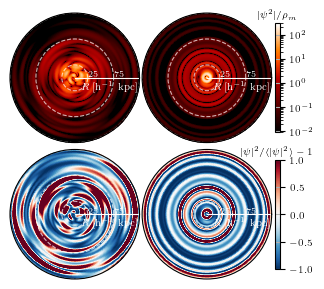

In [22]:
from matplotlib.colors import LogNorm

m22 = 2
method="lasso"
M_cylinder=5e9

t =[ 0 * u.from_Myr]
fig, axss = plt.subplots(ncols=2, nrows=2, figsize=(columnwidth, 1.618*columnwidth),subplot_kw=dict(projection='polar'))

cmap1 = shiftedColorMap(matplotlib.colormaps['gist_heat'], midpoint=0.5)
cmap2 = shiftedColorMap(matplotlib.colormaps['RdBu_r'], midpoint=0.5)

for j, (axs, beta) in enumerate(zip(axss.T, [0.0, 0.5])):
    u = units[m22]
    Rmin = .1 * u.from_Kpc
    Rmax = 200 * u.from_Kpc #rho[(m22,beta)].R99
    R_phi_domain = UniformHypercube([500,500],np.array([[Rmin, 1.0* Rmax],[0,2*np.pi]]))
    Rphi = R_phi_domain.cell_centers_meshgrid
    R, phi = R_phi_domain.cell_centers_cartesian[:,0], R_phi_domain.cell_centers_cartesian[:,1]
    domain = R_phi_domain
    tag = (M_cylinder,m22,beta,method)
    _psi = jax.vmap(lambda R, phi: psi.psi(R, phi, t[0], wavefunction_params[tag]), in_axes=(0,0))
    rho_static = jax.vmap(lambda R: psi.rho(R, wavefunction_params[tag]), in_axes=0)

    psi_Rphit = _psi(R,phi).reshape(domain.N)
    rho_Rphit = np.abs(psi_Rphit)**2
    rho_static_Rphi = rho_static(R).reshape(domain.N)
    
    im = axs[0].pcolormesh(Rphi[1], Rphi[0] * h*u.to_Kpc, rho_Rphit, norm=LogNorm(vmin=9e-3, vmax=3e2), cmap=cmap1, rasterized=True)
    im2 = axs[1].pcolormesh(Rphi[1], Rphi[0] * h*u.to_Kpc, rho_Rphit/rho_static_Rphi-1, vmin=-1, vmax=1, cmap=cmap2, rasterized=True)

    for i,ax in enumerate(axs):
        ax.set_rlim(Rmin * h*u.to_Kpc, 0.9*Rmax *h* u.to_Kpc)
        rtick_loc = [25, 75, 125]
    
        ax.set_rticks(rtick_loc)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.grid(axis="y", ls="dashed")

        #Phi direction
        ax.set_xticklabels([])
        ax.set_xticks([0.0], minor=False)

        # R direction
        ax.text(0.55, .41, r"$R\; \mathrm{[h^{-1}\;kpc]}$", transform=ax.transAxes, zorder=10, c="white")
        ax.set_rlabel_position(0)

        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')
        ax.grid(color="white")
            
        ax.grid(axis="y", ls="dashed", alpha=0.7)
    
cax = fig.add_axes([0.91, .52, 0.015, .2])
cb = fig.colorbar(im,orientation="vertical",cax=cax)
cax.text(.5, 1.05, r"$|\psi^2|/\rho_m$", transform=cax.transAxes, ha="center")

cax2 = fig.add_axes([.91, 0.27, .015, 0.2])
cb2 = fig.colorbar(im2,orientation="vertical",cax=cax2)
cax2.xaxis.set_label_position('top') 
cax2.xaxis.tick_top()
cax2.text(.5, 1.05, r"$|\psi|^2/\langle |\psi|^2 \rangle - 1$", transform=cax2.transAxes, ha="center")

fig.subplots_adjust(wspace=0.02, hspace=-0.52)

if not save:
    plt.show()
else:
    plt.savefig(f"{save_dir}/crossection_overview_small_beta_{beta:.1f}_z_{z:.1f}_m_{m22:.1f}.pdf", dpi=300, format="PDF", bbox_inches="tight", pad_inches=0.01)

## Figure 8

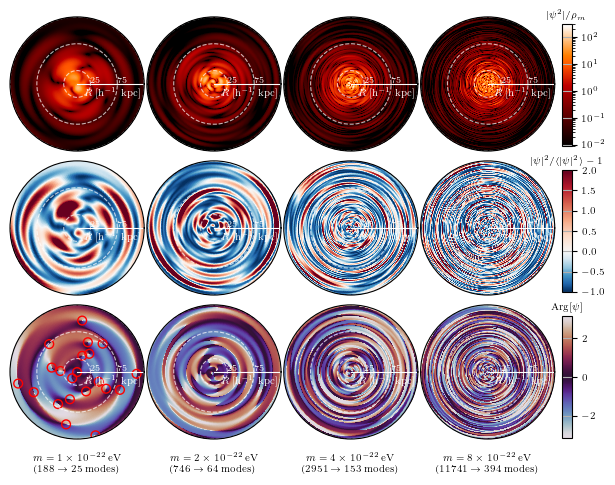

In [23]:
from sklearn.cluster import DBSCAN

M_cylinder=5e9
beta = 0.0
method="lasso"
t =[ 0 * u.from_Myr]
fig, axss = plt.subplots(ncols=4, nrows=3, figsize=(textwidth, 1.8*columnwidth),subplot_kw=dict(projection='polar'))

cmap1 = shiftedColorMap(matplotlib.colormaps['gist_heat'], midpoint=0.5)
cmap2 = shiftedColorMap(matplotlib.colormaps['RdBu_r'], midpoint=0.33)
cmap3 = shiftedColorMap(matplotlib.colormaps['twilight'], midpoint=0.5)

for axs, m22 in zip(axss.T, [1.0, 2.0, 4.0, 8.0]):
    tag = (M_cylinder,m22,beta)
    u = units[m22]
    Rmin = .1 * u.from_Kpc
    Rmax = 200 * u.from_Kpc #rho[(m22,beta)].R99
    R_phi_domain = UniformHypercube([500,500],np.array([[Rmin, 1.0* Rmax],[0,2*np.pi]]))
    Rphi = R_phi_domain.cell_centers_meshgrid
    R, phi = R_phi_domain.cell_centers_cartesian[:,0], R_phi_domain.cell_centers_cartesian[:,1]
    domain = R_phi_domain
    
    _psi = jax.vmap(lambda R, phi: psi.psi(R, phi, t[0], wavefunction_params[tag + (method,)]), in_axes=(0,0))
    _vorticity = jax.vmap(lambda R, phi: psi.vorticity(R, phi, t[0], wavefunction_params[tag + (method,)]), in_axes=(0,0))
    rho_static = jax.vmap(lambda R: psi.rho(R, wavefunction_params[tag + (method,)]), in_axes=0)

    psi_Rphit = _psi(R,phi).reshape(domain.N)
    rho_Rphit = np.abs(psi_Rphit)**2
    rho_static_Rphi = rho_static(R).reshape(domain.N)
    
    im = axs[0].pcolormesh(Rphi[1], Rphi[0] * h*u.to_Kpc, rho_Rphit, norm=LogNorm(vmin=9e-3, vmax=3e2), cmap=cmap1, rasterized=True)
    im2 = axs[1].pcolormesh(Rphi[1], Rphi[0] * h*u.to_Kpc, rho_Rphit/rho_static_Rphi-1, vmin=-1, vmax=2, cmap=cmap2, rasterized=True)
    im3 = axs[2].pcolormesh(Rphi[1], Rphi[0] * h*u.to_Kpc, np.angle(psi_Rphit), vmin=-np.pi, vmax=np.pi, cmap=cmap3, rasterized=True)
    axs[2].text(0.5, -0.15, rf"$m = {latex_float(m22 * 1e-22)}\; \mathrm{{ eV}}$", transform=axs[2].transAxes, ha="center")
    axs[2].text(0.5, -0.25, rf"$({eigenstate_lib[tag].J} \to {wavefunction_params[tag + (method,)].eigenstate_library.J}\; \mathrm{{modes}})$", transform=axs[2].transAxes, ha="center")

    if m22 < 2.0:
        omega = _vorticity(R, phi).reshape(domain.N)
        omega_1d=gaussian_filter(np.abs(omega), 1, mode='nearest').flatten()
        mean = np.mean(omega_1d)
        omega_1d_mean = onp.array(omega_1d/mean)
        peaks = peaks = find_peaks(omega_1d_mean, height=4.0, distance=domain.N[1])[0]
        peak_idx = np.unravel_index(peaks, domain.N)
        R, phi = domain.cell_centers
        
        X = np.c_[R[peak_idx[0]] * np.cos(phi[peak_idx[1]]),R[peak_idx[0]] * np.sin(phi[peak_idx[1]])]
        res = DBSCAN(eps=0.5, min_samples=1).fit(X)

        cs = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(set(res.labels_)))]
        for l,k in enumerate(set(res.labels_)):
            class_member_mask = res.labels_ == k
            xy = X[class_member_mask]
            if k>-1:
                xy = np.mean(xy, axis=0, keepdims=True)
            R = np.sqrt(np.sum(xy**2, axis=-1))
            phi = np.arctan2(xy[:,1],xy[:,0])
            axs[2].scatter(phi, R *h* u.to_Kpc, s=40, facecolors='none', edgecolors="r")
        
    for i,ax in enumerate(axs):
        ax.set_rlim(Rmin * h*u.to_Kpc, 0.9*Rmax * h*u.to_Kpc)
        rtick_loc = [25, 75, 125]
    
        ax.set_rticks(rtick_loc)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.grid(axis="y", ls="dashed")

        #Phi direction
        ax.set_xticklabels([])
        ax.set_xticks([0.0], minor=False)

        # R direction
        ax.text(0.55, .41, r"$R\; \mathrm{[h^{-1}\;kpc]}$", transform=ax.transAxes, zorder=10, c="white")
        ax.set_rlabel_position(0)
    
        
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')

        ax.grid(color="white")
        ax.grid(axis="y", ls="dashed", alpha=0.7)
    
cax = fig.add_axes([0.91, .63, 0.015, .2])
cb = fig.colorbar(im,orientation="vertical",cax=cax)
cax.text(.5, 1.05, r"$|\psi^2|/\rho_m$", transform=cax.transAxes, ha="center")

cax2 = fig.add_axes([.91, 0.39, .015, 0.2])
cb2 = fig.colorbar(im2,orientation="vertical",cax=cax2)
cax2.xaxis.set_label_position('top') 
cax2.xaxis.tick_top()
cax2.text(.5, 1.05, r"$|\psi|^2/\langle |\psi|^2 \rangle - 1$", transform=cax2.transAxes, ha="center")

cax3 = fig.add_axes([.91, 0.15, .015, 0.2])
cb3 = fig.colorbar(im3,orientation="vertical",cax=cax3)
cax3.xaxis.set_label_position('top') 
cax3.xaxis.tick_top()
cax3.text(.5, 1.05, r"$\mathrm{Arg}[\psi]$", transform=cax3.transAxes, ha="center")

fig.subplots_adjust(wspace=0.02, hspace=-0.2)

if not save:
    plt.show()
else:
    plt.savefig(f"{save_dir}/crossection_overview_beta_{beta:.1f}_z_{z:.1f}_m_{m22:.1f}.pdf", dpi=450, format="PDF", bbox_inches="tight", pad_inches=0.01)

**For Figure 9, 10 see ellipsoidal_collapse notebook** 

## Figure 11

Figure 11 will require a three dimensional box defined in parameters/L_2.00_N_1024_Ncyl_8_m22_1.00_aLASSO_seed_20.yaml.
To generate this box run:
```sh
$ ./populate_box.sh <NPROC> <HOSTFILE> parameters/L_2.00_N_1024_Ncyl_8_m22_1.00_aLASSO_seed_20.yaml
```

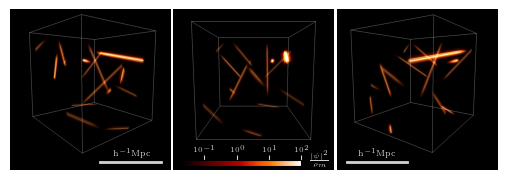

In [11]:
import matplotlib as mpl

fig, ax = plt.subplots(ncols=3,figsize=(textwidth, 0.618*columnwidth), sharey=True)
for ii, i in enumerate([4,44,80]):
    ax[ii].set_box_aspect(1)
    image = plt.imread(f"{save_dir}/rotate_box_L_2.00_N_1024_Ncyl_8_m22_1.00_aLASSO_seed_20_{i}.png")
    ax[ii].grid(False)
    ax[ii].axis('off')
    ax[ii].imshow(np.roll(image,-65, axis=0))
ax[0].plot([450,750],[760,760],c="lightgray",lw=2)
ax[0].text(0.76, 0.09, r"$\mathrm{h^{-1} Mpc}$", c="lightgray", transform=ax[0].transAxes, 
           ha="center", fontsize=6)
ax[2].plot([50,350],[760,760],c="lightgray",lw=2)
ax[2].text(0.25, 0.09, r"$\mathrm{h^{-1} Mpc}$", c="lightgray", transform=ax[2].transAxes, 
           ha="center", fontsize=6)

bounds = (2e-2, 1e2)
cmap = mpl.colormaps['gist_heat'].copy()
norm = mpl.colors.LogNorm(vmin=bounds[0], vmax=bounds[1])
cax = fig.add_axes([0.41,0.13,0.17,.028])

cax.xaxis.label.set_color('white')
cax.tick_params(axis='x', colors='lightgray')

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),orientation="horizontal",
                  cax=cax)
cb.ax.xaxis.set_ticks_position("top")

cb.ax.xaxis.label.set_color("lightgray")
cb.ax.xaxis.set_tick_params(labelsize=5, pad=2)

ax[1].text(0.85, 0.05, r"$\frac{|\psi|^2}{\rho_m}$", transform=ax[1].transAxes,  ha="left", c="lightgray", fontsize=6)
cax.grid(False)

fig.subplots_adjust(wspace=-0.25, hspace=0.0)

plt.show()
#plt.savefig(f"{save_dir}/box_rotate_z_{4.0:.1f}_m_{1.0:.2f}.png", dpi=800, bbox_inches="tight", pad_inches=0.01)

## Single Filament Powerspectra

In [24]:
def _construct_u_0(f_0, rho, r, dln, offset):
    result_shape = jax.ShapeDtypeStruct(f_0.shape, f_0.dtype)
    hankel_f_0_rho = jnp.asarray(jax.pure_callback(_H_0, result_shape, r * f_0, dln, offset))
    return  hankel_f_0_rho / rho

        
def _H_0(f_0, dln, offset):
    f_0 = np.asarray(f_0)
    return 2*jnp.pi * fft.fht(f_0, dln, mu=0, bias=0.0, offset=offset)


def normalised_disctete_polar_powerspectrum_bg(density_params, L, r_min, r_max, N_r):

    # Define discrete polar grid in k-space (k_r, l, k_z)
    r = jnp.logspace(jnp.log10(r_min), jnp.log10(r_max), N_r)
    dln = jnp.log(r[1]/r[0])
    offset = 0
    rho= jnp.exp(offset)/r[::-1]

    # Hankel transform each coefficient to get spectral representation in log uniform rho
    density = SteadyStateCylinder(**density_params)
    f_0 = density(r)
    u_0_rho = _construct_u_0(f_0, rho, r, dln, offset)
    return rho, u_0_rho/(density.total_mass * L)

In [29]:
import jax.numpy as jnp
from functools import partial
import scipy.fft as fft
import fuzzylli.interpolation_jax as interpolate
from quadax import quadcc

_eval_library = jax.vmap(eval_eigenstate, in_axes=(None, 0))
_correlate = jax.vmap(jax.vmap(lambda a,b: jnp.correlate(a,b, mode="full"), in_axes=(0,None)), in_axes=(None,0))
_ifftshift = jax.vmap(jnp.fft.ifftshift)

def _reinit_random_phases(eigenstate_library, key):
    l, m, q = jax.random.split(key, 3)
    phase = jnp.where(
        (eigenstate_library.l_of_j > 0).reshape(-1, 1),
        jnp.exp(
            1.0j
            * jax.random.uniform(
                l,
                shape=(eigenstate_library.J, 2),
                maxval=2 * jnp.pi,
            )
        ),
        0,
    )
    phase0 = jnp.where(
        eigenstate_library.l_of_j == 0,
        jnp.exp(
            1.0j
            * jax.random.uniform(
                m,
                shape=(eigenstate_library.J,),
                maxval=2 * jnp.pi,
            )
        ),
        0,
    )
    phase0 = jnp.c_[phase0, phase0]
    return phase0 + phase, q

def normalised_disctete_polar_powerspectrum(psi_params, L, r_min, r_max, N_r, key):

    @jax.jit
    def _construct_f_m(r, aR_nl):
        def populate(j, aR_nl):
            aR_nl = aR_nl.at[n_of_j[j], l_max - l_of_j[j]].add(a_j[j] * R_j[j] * phase_j[j,0])
            aR_nl = aR_nl.at[n_of_j[j], l_max + l_of_j[j]].add(a_j[j] * R_j[j] * phase_j[j,1])
            
            return aR_nl
            
        R_j = jnp.sqrt(psi_params.total_mass / (2 * jnp.pi)) * _eval_library(r, lib.R_j_params)
        aR_nl_r =  jax.lax.fori_loop(
            0,
            lib.J,
            populate,
            aR_nl
        )

        # This is the Fourier coefficient of |psi|^2 of mode exp(i m phi)
        f_m = jnp.sum(_correlate(aR_nl_r, aR_nl_r), axis=(0,1))

        return f_m

    
    @partial(jax.vmap, in_axes=(1,0,None,None), out_axes=1)
    def _construct_u_m(f_m, m, rho, r):
        result_shape = jax.ShapeDtypeStruct(f_m.shape, f_m.dtype)
        hankel_f_m_rho = jnp.asarray(jax.pure_callback(_H_m, result_shape, r * f_m, m))
        return 2*jnp.pi * 1.0j**-m * hankel_f_m_rho / rho

        
    def _H_m(cmplx_m, m):
        cmplx_m = np.asarray(cmplx_m)
        real = fft.fht(cmplx_m.real, dln, mu=m, bias=0.)
        imag = fft.fht(cmplx_m.imag, dln, mu=m, bias=0.)
        return real + 1.0j * imag
        
    # Unpack wavefunction parameters
    lib = psi_params.eigenstate_library
    n_of_j  = lib.n_of_j
    l_of_j  = (lib.l_of_j).astype(int)
    n_max = jnp.max(n_of_j)
    l_max = l_of_j[-1]
    a_j = psi_params.a_j 
    phase_new, key = _reinit_random_phases(lib, key)
    phase_j = psi_params.phase_j * phase_new

    # Define discrete polar grid in k-space (k_r, l, k_z)
    r = jnp.logspace(jnp.log10(r_min), jnp.log10(r_max), N_r)
    dln = jnp.log(r[1]/r[0])
    offset=0
    rho= jnp.exp(offset)/r[::-1]

    # Compute azimuthal Fourier coefficients for normalised |psi|^2
    aR_nl = jnp.zeros((n_max + 1, 2*l_max + 1), dtype=complex)
    f_m = jax.lax.map(lambda r: _construct_f_m(r, aR_nl), r)

    # Hankel transform each coefficient to get spectral representation in log uniform rho
    m_max = (f_m.shape[-1] - 1)//2
    m = jnp.arange(m_max+1)
    u_m_rho = _construct_u_m(f_m[:,m_max:], m, rho, r)
    u_m_neg_rho = (-1)**m[None, :0:-1] * jnp.conjugate(u_m_rho[:,:0:-1])
    u_m_rho = jnp.hstack([u_m_rho, u_m_neg_rho])

    # Sum over all m modes to get spectral representation in (rho, omega)
    u_mn = jnp.fft.ifft(u_m_rho, norm="forward", axis=-1)
    higher_l_states = l_of_j > 0

    norm = np.sum(2*np.abs(a_j[higher_l_states])**2)+np.sum(np.abs(a_j[np.logical_not(higher_l_states)])**2)
    return rho, u_mn/(psi_params.total_mass * norm * L), key

In [30]:
products = {}
beta = 0.0
routine="lasso"
a = 0.2
M_cylinder=5e9
for m22 in [1,2,4,8]:
    tag = (M_cylinder,m22,beta)
    print(tag)
    u = set_units(m22)
    psi_params = wavefunction_params[tag + (routine,)]
    r0 = rho[tag].r0
    R50 = rho[tag].enclosing_radius(0.5)
    sigma2 = rho[tag].r0
    density_params = {
        "beta": beta,
        "scalefactor": a,
        "r0": r0,
        "sigma2": rho[tag].sigma2
    }
    key = jax.random.PRNGKey(1)
    products[m22] = {"units":u, "psi_params":psi_params, "density_params":density_params, "r0":r0, "R50":R50}

(5000000000.0, 1, 0.0)
(5000000000.0, 2, 0.0)
(5000000000.0, 4, 0.0)
(5000000000.0, 8, 0.0)


In [31]:
from tqdm import tqdm

N_r = 1024
for m22 in products.keys():
    u = products[m22]["units"]
    r_min = 0.01 * u.from_pc * h**-1
    r_max = 5 * u.from_Mpc * h**-1
    L = 1.0 * u.from_Mpc * h**-1
    density_params = products[m22]["density_params"]
    psi_params = products[m22]["psi_params"]
    
    K, u_K_bg = normalised_disctete_polar_powerspectrum_bg(density_params, L, r_min, r_max, N_r)
    u_Ks = []
    
    for M in tqdm(range(16)):
        K, u_K, key = normalised_disctete_polar_powerspectrum(psi_params, L, r_min, r_max, N_r, key)
        u_Ks.append(u_K)
       
    products[m22]["K"] = K
    products[m22]["u_K_bg"] = u_K_bg
    products[m22]["u_Ks"] = u_Ks

100%|████████████████████| 16/16 [01:48<00:00,  6.75s/it]


(5000000000.0, 1, 0.0)
(5000000000.0, 2, 0.0)
(5000000000.0, 4, 0.0)
(5000000000.0, 8, 0.0)


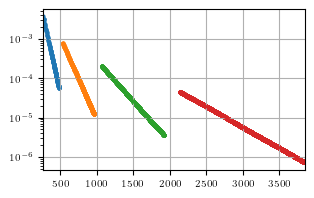

In [33]:
fig, ax = plt.subplots(figsize=(columnwidth,columnwidth * 0.618))
#ax.set_xscale("log")
ax.set_yscale("log")

from scipy.optimize import curve_fit
def fE(E, a, s):
     return a * jnp.exp(-E/s**2)

for m22 in products.keys():
    tag = (M_cylinder, m22, beta)
    print(tag)
    psi_params = wavefunction_params[tag + ("wkb",)]
    
    index = jnp.argsort(psi_params.eigenstate_library.E_j)
    E_j = psi_params.eigenstate_library.E_j[index]
    a_j2 = psi_params.a_j[index]**2

    #Cut lower energy
    E_j = E_j[index.shape[0]//10:]
    a_j2 = a_j2[index.shape[0]//10:]
    popt, _ = curve_fit(fE, E_j, a_j2, p0=[0.1,20], bounds=([0,0,],[np.inf, np.inf]))
    lambda_dB_h = 1.0/(jnp.sqrt(2) * popt[1])
    ax.scatter(E_j, a_j2, s=4)
    plt.plot(E_j, fE(E_j, *popt))
    products[m22]["lambda_db_h"] = lambda_dB_h
plt.show()

In [34]:
def select_eigenmode_nl(n, l, lib):
    n = lib.n_of_j == n
    l = lib.l_of_j == l
    return jax.tree_util.tree_map(
        lambda param: param[jnp.logical_and(n, l)],
        lib,
    )
    
def compute_r_pow_exp(pow, R_max, lib):
    def integrand(r, pow, lib):
        return r**(1+pow) * jnp.abs(_eval_library(r, lib.R_j_params))**2

    exp_r_pow, info = quadax.quadts(integrand, (0.0, R_max), (pow, lib,))
    norm, info = quadax.quadts(integrand, (0.0, R_max), (0, lib,))
    return exp_r_pow/norm

In [35]:
import quadax
import fuzzylli.interpolation_jax as interpolate

def p_kz(kz, L):
    epsilon = 10/L
    return jnp.abs(jnp.sqrt(2/jnp.pi)*jnp.exp(-kz**2/(4*epsilon**2))*jnp.sin(kz*L/2)/kz)**2

def integrand(k_z, k, L, log_K_P_K_params):
    return  p_kz(k_z, L) * interpolate.eval_interp1d(jnp.log10(jnp.sqrt(k**2 - k_z**2)), log_K_P_K_params)

@partial(jax.vmap, in_axes=(0,None,None))
def isotropized_powerspectrum(k, L, log_K_P_K_params):
    k_P_k, info = quadax.quadts(integrand, (0.0, k), (k, L, log_K_P_K_params))#, epsrel=1e-12, epsabs=1e-12)
    return 2*jnp.pi/k * k_P_k, info

## 1-Filament Power Spectrum

Code below is repetetive due to slight API missmatches and parellelisation. 
TODO: Refactor all of this

In [41]:
from fuzzylli.powerspectrum import init_normalised_polar_powerspectrum,normalised_polar_powerspectrum, eval_normalised_polar_powerspectrum
from fuzzylli.units import cgs_units

from distributed import Client, get_client, secede, rejoin
from dask import delayed, compute
import quadax

In [42]:
def normalised_cylindrical_powerspectrum(k, L, power_params):
    def p_kz(kz, L):
        epsilon = 10/L
        return jnp.abs(jnp.sqrt(2/jnp.pi)*jnp.exp(-kz**2/(4*epsilon**2))*jnp.sin(kz*L/2)/kz)**2

    def integrand(k_z, k, L, log_K_P_K_params):
        return p_kz(k_z, L) * eval_normalised_polar_powerspectrum(
            jnp.sqrt(k**2 - k_z**2), log_K_P_K_params
        )

    k_P_k, info = quadax.quadts(integrand, (0.0, k), (k, L, power_params))
    return 2.0 * jnp.pi / k * k_P_k


def dn_dM(M, fmf_params, u):
    M = M * u.to_Msun
    in_MsunMpc3 = (
        interpolate.eval_interp1d(jnp.log10(M * cgs_units.from_Msun), fmf_params)
        * 1.0
        / (cgs_units.to_Msun * cgs_units.to_Mpc**3)
    )
    return in_MsunMpc3 * 1.0 / (u.from_Msun * u.from_Mpc**3)


def rho_mean(M_min, M_max, fmf_params, u):
    @partial(jax.vmap, in_axes=(0, None))
    def integrand(logM, fmf_params):
        M = jnp.exp(logM)
        return M**2 * dn_dM(M, fmf_params, u)

    logM = jnp.linspace(jnp.log(M_min), jnp.log(M_max), 64)
    i = integrand(logM, fmf_params)
    rho_m = quadax.simpson(i, x=logM)

    return rho_m

In [43]:
def r0_mean(M_min, M_max, fmf_params, u, N_quad=64):
    def init_r0(u, M_cylinder, beta, z):
        a = 1.0 / (z + 1)

        # Background Density
        params_rho_steady_state = {
            "scalefactor": a,
            "r0": h**-1
            * cylinder_scale_radius_physical_Mpc(M_cylinder * u.to_Msun, beta)
            * u.from_Mpc,
            "sigma2": (
                cylinder_sqrt_v_dispersion_physical_kms(M_cylinder * u.to_Msun, beta)
                * u.from_kms
            )
            ** 2,
        }
        params_rho_steady_state["beta"] = beta
        rho = SteadyStateCylinder(**params_rho_steady_state)
        return rho.r0
    
    @partial(jax.vmap, in_axes=(0, None))
    def integrand_num(logM, fmf_params):
        M = jnp.exp(logM)
        r0 = init_r0(u, M, beta, z)
        return M**3 * dn_dM(M, fmf_params, u) * r0

    @partial(jax.vmap, in_axes=(0, None))
    def integrand_denom(logM, fmf_params):
        M = jnp.exp(logM)
        return M**3 * dn_dM(M, fmf_params, u)

    beta = 0.0
    z = 4
    logM = jnp.linspace(jnp.log(M_min), jnp.log(M_max), N_quad)
    num = integrand_num(logM, fmf_params)
    denom = integrand_denom(logM, fmf_params)

    return quadax.simpson(num, x=logM)/quadax.simpson(denom, x=logM)

def r_exp_pow_mean(M_min, M_max, fmf_params, u, cache_dir, N_psi=1024, N_quad=64):
    
    def init_rho_lib(u, M_cylinder, beta, z, N, cache_dir):
        a = 1.0 / (z + 1)

        # Background Density
        params_rho_steady_state = {
            "scalefactor": a,
            "r0": h**-1
            * cylinder_scale_radius_physical_Mpc(M_cylinder * u.to_Msun, beta)
            * u.from_Mpc,
            "sigma2": (
                cylinder_sqrt_v_dispersion_physical_kms(M_cylinder * u.to_Msun, beta)
                * u.from_kms
            )
            ** 2,
        }
        params_rho_steady_state["beta"] = beta
        rho = SteadyStateCylinder(**params_rho_steady_state)

        # Gravitational Potential
        source = lambda R: rho(R) / a
        source.name = rho.name
        V = AxialSymmetricPotential(source, rho.R999)

        # Eigenstate Library
        kwargs = {
            "for_name": [a, V.name, V(rho.R99), N],
            "for_compute": [a, V, V(rho.R99), N],
        }
        name, eigenstate_lib = load_or_compute_model(
            True,
            cache_dir,
            eigenstate_library.compute_name,
            init_eigenstate_library,
            **kwargs,
        )
        save_model(False, cache_dir, name, eigenstate_lib)

        return rho, select_eigenmode_nl(0, 0, eigenstate_lib)
    
    def integrand_num(logM, fmf_params):
        M = jnp.exp(logM)
        rho, gs = init_rho_lib(u, M, beta, z, N_psi, cache_dir)
        return M**3 * dn_dM(M, fmf_params, u) * compute_r_pow_exp(1, rho.R999, gs).squeeze()

    @partial(jax.vmap, in_axes=(0, None))
    def integrand_denom(logM, fmf_params):
        M = jnp.exp(logM)
        return M**3 * dn_dM(M, fmf_params, u)

    client = get_client()
    beta = 0.0
    z = 4
    logM = jnp.linspace(jnp.log(M_min), jnp.log(M_max), N_quad)
    num = client.map(lambda logM: integrand_num(logM, fmf_params), logM)
    secede()
    num = jnp.array(client.gather(num))
    rejoin()
    denom = integrand_denom(logM, fmf_params)

    return quadax.simpson(num, x=logM)/quadax.simpson(denom, x=logM)

from scipy.optimize import curve_fit
def lambda_dB_mean(M_min, M_max, fmf_params, u, cache_dir, N_quad=64):
    def fE(E, norm, s):
        return norm * jnp.exp(-E/s**2)
        
    def init_rho_V_df(u, M_cylinder, beta, z, cache_dir):
        a = 1.0 / (z + 1)

        # Background Density
        params_rho_steady_state = {
            "scalefactor": a,
            "r0": h**-1
            * cylinder_scale_radius_physical_Mpc(M_cylinder * u.to_Msun, beta)
            * u.from_Mpc,
            "sigma2": (
                cylinder_sqrt_v_dispersion_physical_kms(M_cylinder * u.to_Msun, beta)
                * u.from_kms
            )
            ** 2,
        }
        params_rho_steady_state["beta"] = beta
        rho = SteadyStateCylinder(**params_rho_steady_state)

        # Gravitational Potential
        source = lambda R: rho(R) / a
        source.name = rho.name
        V = AxialSymmetricPotential(source, rho.R999)

        # Phase Space DF
        df_kwargs = {"R_min": 0.1 * u.from_Kpc, "R_max": rho.R999, "epochs": 20000}
        kwargs = {
            "for_name": [params_rho_steady_state["beta"], a, V, rho],
            "for_compute": [params_rho_steady_state["beta"], a, V, rho],
        }
        name = ConstantAnisotropyDistribution.compute_name(*kwargs["for_name"], **df_kwargs)
        if os.path.exists(f"{cache_dir}/{name}"):
            compute_args = kwargs["for_compute"]
            df_params = load_model(cache_dir, name)
            df = ConstantAnisotropyDistribution(
                *compute_args, **df_kwargs, df_params=df_params
            )
        else:
            print("No model found/Recompute enforced. Compute it...")
            compute_args = kwargs["for_compute"]
            df = ConstantAnisotropyDistribution(*compute_args, **df_kwargs)
            save_model(False, cache_dir, name, df.df_params)

        return rho, V, df
    
    def integrand_num(logM, fmf_params):
        M = jnp.exp(logM)
        a = 1.0 / (z + 1)
        rho, V, df = init_rho_V_df(u, M, beta, z, cache_dir)
        l = 0
        Emin = E_c(psi.L(l),V,a)
        E = np.linspace(Emin,V(rho.R99), 100)[10:]
        fE_true = df(E, psi.L(l)*np.ones_like(E))* (2*np.pi)**2/rho.total_mass
    
        popt, _ = curve_fit(fE, E, fE_true, p0=[0.1,20], bounds=([0,0,],[np.inf, np.inf]))
        lambda_dB_h = 1.0/(jnp.sqrt(2) * popt[1])
        return M**3 * dn_dM(M, fmf_params, u) * lambda_dB_h

    @partial(jax.vmap, in_axes=(0, None))
    def integrand_denom(logM, fmf_params):
        M = jnp.exp(logM)
        return M**3 * dn_dM(M, fmf_params, u)
    
    client = get_client()
    beta = 0.0
    z = 4
    logM = jnp.linspace(jnp.log(M_min), jnp.log(M_max), N_quad)
    num = client.map(lambda logM: integrand_num(logM, fmf_params), logM)
    secede()
    num = jnp.array(client.gather(num))
    rejoin()
    denom = integrand_denom(logM, fmf_params)

    return quadax.simpson(num, x=logM)/quadax.simpson(denom, x=logM)

In [44]:
def _construct_u_0(f_0, rho, r, dln, offset, bias):
    result_shape = jax.ShapeDtypeStruct(f_0.shape, f_0.dtype)
    hankel_f_0_rho = jnp.asarray(
        jax.pure_callback(_H_0, result_shape, r * f_0, dln, offset, bias)
    )
    return hankel_f_0_rho / rho


def _H_0(f_0, dln, offset, bias):
    f_0 = np.asarray(f_0)
    return 2 * jnp.pi * fft.fht(f_0, dln, mu=0, bias=bias, offset=offset)


def normalised_disctete_polar_powerspectrum_bg(K, density_params, L, offset, bias):
    # Define discrete polar grid in k-space (k_r, l, k_z)
    r = jnp.exp(offset) / K[::-1]
    dln = jnp.log(r[1] / r[0])

    # Hankel transform each coefficient to get spectral representation in log uniform rho
    density = SteadyStateCylinder(**density_params)
    f_0 = density(r) / (density.total_mass * L)
    u_0_rho = _construct_u_0(f_0, K, r, dln, offset, bias)

    return u_0_rho


def init_P_1f_bg(M_min, M_max, fmf_params, u, N_H=1024, offset=0, bias=0.3, N_quad=64):
    def compute_P_bg_params(logM):
        M = jnp.exp(logM)
        density_params = {
            "beta": beta,
            "scalefactor": a,
            "r0": h**-1
            * cylinder_scale_radius_physical_Mpc(M * u.to_Msun, beta)
            * u.from_Mpc,
            "sigma2": (
                cylinder_sqrt_v_dispersion_physical_kms(M * u.to_Msun, beta)
                * u.from_kms
            )
            ** 2,
        }
        r_min = 0.01 * u.from_pc
        r_max = 5 * u.from_Mpc
        L = cylinder_length_physical_Mpc(M * u.to_Msun) * (1 + z) * u.from_Mpc
        r = jnp.logspace(jnp.log10(r_min), jnp.log10(r_max), N_H)
        K = jnp.exp(offset) / r[::-1]
        u_k_bg = normalised_disctete_polar_powerspectrum_bg(
            K, density_params, L, offset, bias
        )
        logK = jnp.log10(K)
        P_bg_params = interpolate.init_1d_interpolation_params(
            logK[0], logK[1] - logK[0], jnp.abs(u_k_bg) ** 2
        )

        return L, normalised_polar_powerspectrum(P_params=P_bg_params)

    client = get_client()
    beta = 0.0
    z = 4
    a = 1.0 / (z + 1)
    logM = jnp.linspace(jnp.log(M_min), jnp.log(M_max), N_quad)
    
    L_P_bg_params = client.map(compute_P_bg_params, logM)
    secede()
    L_P_bg_params = client.gather(L_P_bg_params)
    L, P_bg_params = zip(*L_P_bg_params)
    L = jnp.array(L)
    P_bg_params = jax.tree_util.tree_map(lambda *xs: jnp.array(xs), *P_bg_params)
    
    return rho_mean(M_min, M_max, fmf_params, u), logM, L, P_bg_params

In [45]:
def init_P_1f_psi(
    M_min,
    M_max,
    fmf_params,
    u,
    key,
    cache_dir,
    N_psi=1024,
    N_H=1024,
    offset=0,
    bias=0.3,
    N_real=8,
    N_quad=64,
    routine="wkb",
):
    @delayed
    def init_fdm_cylinder(u, M_cylinder, beta, z, N, seed, cache_dir, routine="wkb"):
        a = 1.0 / (z + 1)

        # Background Density
        params_rho_steady_state = {
            "scalefactor": a,
            "r0": h**-1
            * cylinder_scale_radius_physical_Mpc(M_cylinder * u.to_Msun, beta)
            * u.from_Mpc,
            "sigma2": (
                cylinder_sqrt_v_dispersion_physical_kms(M_cylinder * u.to_Msun, beta)
                * u.from_kms
            )
            ** 2,
        }
        params_rho_steady_state["beta"] = beta
        rho = SteadyStateCylinder(**params_rho_steady_state)

        # Gravitational Potential
        source = lambda R: rho(R) / a
        source.name = rho.name
        V = AxialSymmetricPotential(source, rho.R999)

        # Phase Space DF
        df_kwargs = {"R_min": 0.1 * u.from_Kpc, "R_max": rho.R999, "epochs": 20000}
        kwargs = {
            "for_name": [params_rho_steady_state["beta"], a, V, rho],
            "for_compute": [params_rho_steady_state["beta"], a, V, rho],
        }
        name = ConstantAnisotropyDistribution.compute_name(*kwargs["for_name"], **df_kwargs)
        if os.path.exists(f"{cache_dir}/{name}"):
            compute_args = kwargs["for_compute"]
            df_params = load_model(cache_dir, name)
            df = ConstantAnisotropyDistribution(
                *compute_args, **df_kwargs, df_params=df_params
            )
        else:
            print("No model found/Recompute enforced. Compute it...")
            compute_args = kwargs["for_compute"]
            df = ConstantAnisotropyDistribution(*compute_args, **df_kwargs)
            save_model(False, cache_dir, name, df.df_params)

        # Eigenstate Library
        kwargs = {
            "for_name": [a, V.name, V(rho.R99), N],
            "for_compute": [a, V, V(rho.R99), N],
        }
        name, eigenstate_lib = load_or_compute_model(
            True,
            cache_dir,
            eigenstate_library.compute_name,
            init_eigenstate_library,
            **kwargs,
        )
        save_model(False, cache_dir, name, eigenstate_lib)

        # Wavefunction coefficients
        init_routine = {
            "wkb": [psi.init_wavefunction_params_wkb, seed],
            "lasso": [psi.init_wavefunction_params_adaptive_lasso, seed],
        }
        f = init_routine[routine][0]
        scalar_args = init_routine[routine][1:]
        kwargs = {
            "for_name": [
                routine,
                name,
                rho,
                rho.R99,
                *scalar_args,
            ],
            "for_compute": [eigenstate_lib, rho, df, rho.R99, *scalar_args],
        }

        name, wavefunction_params = load_or_compute_model(
            True, cache_dir, psi.wavefunction_params.compute_name, f, **kwargs
        )
        save_model(False, cache_dir, name, wavefunction_params)

        return wavefunction_params

    def cylinder_name(u, M_cylinder, beta, z, N, seed, cache_dir, routine="wkb"):
        a = 1.0 / (z + 1)

        # Background Density
        params_rho_steady_state = {
            "scalefactor": a,
            "r0": h**-1
            * cylinder_scale_radius_physical_Mpc(M_cylinder * u.to_Msun, beta)
            * u.from_Mpc,
            "sigma2": (
                cylinder_sqrt_v_dispersion_physical_kms(M_cylinder * u.to_Msun, beta)
                * u.from_kms
            )
            ** 2,
        }
        params_rho_steady_state["beta"] = beta
        rho = SteadyStateCylinder(**params_rho_steady_state)

        # Gravitational Potential
        source = lambda R: rho(R) / a
        source.name = rho.name
        V = AxialSymmetricPotential(source, rho.R999)

        # Eigenstate Library
        name = eigenstate_library.compute_name(a, V.name, V(rho.R99), N)

        # Wavefunction coefficients
        init_routine = {
            "wkb": [psi.init_wavefunction_params_wkb, seed],
            "lasso": [psi.init_wavefunction_params_adaptive_lasso, seed],
        }
        scalar_args = init_routine[routine][1:]

        name = psi.wavefunction_params.compute_name(routine,name,rho,rho.R99, *scalar_args)

        return name

    def compute_P_iso_params(logM):
        M = jnp.exp(logM)
        psi_params = init_fdm_cylinder(
            u, M, beta, z, N_psi, SEED, cache_dir, routine=routine
        )
        psi_params_name = cylinder_name(u, M, beta, z, N_psi, SEED, cache_dir, routine=routine)

        r_min = 0.01 * u.from_pc
        r_max = 5 * u.from_Mpc
        L = cylinder_length_physical_Mpc(M * u.to_Msun) * (1 + z) * u.from_Mpc
        keys = jax.random.split(key, N_real)
        kwargs = {
            "for_name": [psi_params_name, r_min, r_max, L, N_H, offset, bias],
            "for_compute": [psi_params, r_min, r_max, L, N_H, offset, bias, keys],
        }
        name, P_iso_params = load_or_compute_model(
            True,
            CACHE_DIR,
            normalised_polar_powerspectrum.compute_name,
            init_normalised_polar_powerspectrum,
            **kwargs,
        )
        
        save_model(True, CACHE_DIR, name, P_iso_params)
        return L, P_iso_params

        
    client = get_client()
    beta = 0.0
    z = 4
    logM = jnp.linspace(jnp.log(M_min), jnp.log(M_max), N_quad)
    
    L_P_iso_params = client.map(compute_P_iso_params, logM)
    secede()
    L_P_iso_params = client.gather(L_P_iso_params)
    L, P_iso_params = zip(*L_P_iso_params)
    L = jnp.array(L)
    P_iso_params = jax.tree_util.tree_map(lambda *xs: jnp.array(xs), *P_iso_params)
    
    return rho_mean(M_min, M_max, fmf_params, u), logM, L, P_iso_params

def eval_P_1f(k, rho_mean, logM, L, P_1f_params):
    @partial(jax.vmap, in_axes=(None, 0, 0, 0))
    def integrand(k, logM, L, P_params):
        M = jnp.exp(logM)
        u2_k = normalised_cylindrical_powerspectrum(k, L, P_params)
        return M**3 * dn_dM(M, fmf_params, u) * u2_k
        
    i = integrand(k, logM, L, P_1f_params)
    return quadax.simpson(i, x=logM) / rho_mean ** 2

### Figure 12

Figure 12 will require a three dimensional box defined in parameters/L_2.00_N_2048_Ncyl_8_m22_1.00_aLASSO_seed_20.yaml
To generate this box run:
```sh
$ ./populate_box.sh <NPROC> <HOSTFILE> parameters/L_2.00_N_2048_Ncyl_8_m22_1.00_aLASSO_seed_20.yaml
```
We also need its power spectrum. Run:
```sh
$ ./powerspectrum.sh <NPROC> <HOSTFILE> <PATH_TO_HDF5_FILE_CREATED_ABOVE>
```
which will add a dataset to the HDF5 file.
Below, we compute the one-filament spectrum via dask-ssh (make sure it is installed and works properly). A convenient way initiate a cluster is via:
```sh
$ dask-ssh --nworkers 16 --memory-limit 430GB <HOSTNAMES>
```
This compuatation (especially for m22>2) will require ***significant ressources (O(TByte) memory)***.

In [51]:
client = get_client("localhost:8786")

CACHE_DIR = "/mn/stornext/u3/timzi/projects/fdm_filaments/data/cache"
m22 = 4
u = set_units(m22)
M_min = 3e9 * u.from_Msun
M_max = 3e10 * u.from_Msun

with open(f"{CACHE_DIR}/fmf_{m22}", mode="rb") as file:
    fmf_params = pickle.load(file)

params_bg = client.submit(init_P_1f_bg, M_min, M_max, fmf_params, u).result()

In [53]:
client = get_client("localhost:8786")

SEED = 42
CACHE_DIR = "/mn/stornext/u3/timzi/projects/fuzzy_filaments/data/cache"

key = jax.random.PRNGKey(SEED)
params_psi = {}
for m22 in [1,2,4]:
    print(m22)
    u = set_units(m22)
    M_min = 3e9 * u.from_Msun
    M_max = 3e10 * u.from_Msun
    with open(f"{CACHE_DIR}/fmf_{m22}", mode="rb") as file:
        fmf_params = pickle.load(file)
    r0 = r0_mean(M_min, M_max, fmf_params, u)
    rho_m, logM, L, P_1f_psi = client.submit(init_P_1f_psi, M_min, M_max, fmf_params, u, key, CACHE_DIR, routine="wkb").result()
    
    params = {}
    params["r0"] = r0
    params["lambda_dB_h"] = client.submit(lambda_dB_mean, M_min, M_max, fmf_params, u, CACHE_DIR).result()
    params["r_exp"] = client.submit(r_exp_pow_mean, M_min, M_max, fmf_params, u, CACHE_DIR).result()
    params["rho_m"] = rho_m
    params["logM"] = logM
    params["L"] = L
    params["P_1f_psi"] = P_1f_psi
    params_psi[m22] = params

1
2
4


In [59]:
file = h5py.File("../data/cylinder_gas/L_2.00_N_2048_Ncyl_8_m22_1.00_aLASSO_seed_20.h5", "r")
k_Pk = file["powerspectrum/0"]
kbox, Pk_box = k_Pk[:,0], k_Pk[:,1]
file.close()

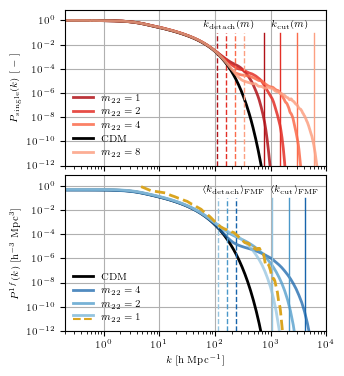

In [58]:
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D

fig, ax = plt.subplots(nrows=2, figsize=(columnwidth, 2*0.618*columnwidth), sharex=True)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")

reds = sns.color_palette("Reds_r", 5)

eval_interp1d = jax.vmap(interpolate.eval_interp1d, in_axes=(0,None))
init_1d_interpolation_params = jax.vmap(interpolate.init_1d_interpolation_params)

reds = sns.color_palette("Reds_r", 5)

for i,m22 in enumerate([1, 2, 4, 8]):
    tag = (M_cylinder,m22,beta)
    u = products[m22]["units"]
    u_Ks = products[m22]["u_Ks"]
    u_K_bg = products[m22]["u_K_bg"]

    K = products[m22]["K"]
    logK = jnp.log10(K)
    
    P_bg_params = interpolate.init_1d_interpolation_params(logK[0], logK[1] - logK[0], jnp.abs(u_K_bg)**2)
    
    P_K_psi = jnp.mean(jnp.abs(jnp.asarray(u_Ks))**2, axis=-1)
    N_real = P_K_psi.shape[0]
    P_psi_params = init_1d_interpolation_params(jnp.repeat(logK[0], N_real), 
                                              jnp.repeat(logK[1] - logK[0], N_real), 
                                              P_K_psi)

    L = 1.0 * u.from_Mpc * h**-1
    k = jnp.logspace(-3, 3, 512)

    P_bg = isotropized_powerspectrum(k, L, P_bg_params)[0]
    P_psi = jnp.mean(jax.vmap(isotropized_powerspectrum, in_axes=(None,None,0))(k, L, P_psi_params)[0], axis=0)
    if m22==8:
        ax[0].plot(k / (u.to_Mpc * h), P_bg, c="k", label=r"$\mathrm{CDM}$")
        r0 = products[m22]["r0"]
        #ax[0].axvline(x=1.0/(r0/a * u.to_Mpc * h), color="dimgray", lw=1.4, ymax=0.85)
    ax[0].plot(k / (u.to_Mpc * h), P_psi, c=reds[i], label=rf"$m_{{22}}={m22}$", alpha=0.85)

    lambda_dB_h = products[m22]["lambda_db_h"]
    ax[0].axvline(x=1 /(lambda_dB_h * u.to_Mpc * h),  c=reds[i], lw=1, ymax=.85)
    R_max = rho[tag].R999
    gs = select_eigenmode_nl(0, 0, eigenstate_lib[tag])
    exp_r = compute_r_pow_exp(1, R_max, gs)
    ax[0].axvline(x=1 /(exp_r * u.to_Mpc * h),  c=reds[i], lw=1, ls="dashed", ymax=0.85)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc="lower left")
ax[0].text(1000, 3e-1, r"$k_\mathrm{cut}(m)$")
ax[0].text(60, 3e-1, r"$k_\mathrm{detach}(m)$")


P_1f = jax.vmap(eval_P_1f, in_axes=(0,None,None,None,None))
blues = sns.color_palette("Blues_r", 4)
for i,m22 in enumerate([4,2,1]):
    u = set_units(m22)
    k = jnp.logspace(-1, 4, 99) / u.from_Mpc
    if m22==4:
        r0 = params_psi[m22]["r0"]
        rho_m, logM, L, P_1f_bg = params_bg
        P = P_1f(k, rho_m, logM, L, P_1f_bg)
        ax[1].plot(k / (u.to_Mpc * h), P * (h * u.to_Mpc)**3, color="black", label=r"$\mathrm{CDM}$")
        #ax[1].axvline(x=1.0/(r0/a * u.to_Mpc * h), color="dimgray", lw=1.4, ymax=0.85)

    lambda_dB_h = params_psi[m22]["lambda_dB_h"]
    exp_r_h = params_psi[m22]["r_exp"]
    rho_m = params_psi[m22]["rho_m"]
    logM = params_psi[m22]["logM"]
    L = params_psi[m22]["L"]
    P_1f_psi = params_psi[m22]["P_1f_psi"]
    
    P = P_1f(k, rho_m, logM, L, P_1f_psi)
    ax[1].plot(k / (u.to_Mpc * h), P * (h * u.to_Mpc)**3 , c=blues[i], label=rf"$m_{{22}}={m22}$", alpha=0.75)
    ax[1].axvline(x=1 /(lambda_dB_h * u.to_Mpc *h), c=blues[i], lw=1, ymax=0.85)
    ax[1].axvline(x=1 /(exp_r_h * u.to_Mpc * h),  c=blues[i], lw=1, ls="dashed", ymax=0.85)

ax[1].plot(kbox, Pk_box, color="goldenrod", ls="dashed", label=r"$m_{22}=1\;\mathrm{(box\;in\;Fig.\;11)}$")
handles, labels = ax[1].get_legend_handles_labels()
handles = handles[:-2]
labels = labels[:-2]

class StackedLineHandler(HandlerBase):
    def __init__(self, colors, linestyles, linewidths):
        super().__init__()
        self.colors = colors
        self.linestyles = linestyles
        self.linewidths = linewidths

    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        artists = []
        for i, (color, linestyle, linewidth) in enumerate(zip(self.colors, self.linestyles, self.linewidths)):
            y_position = ydescent + height * (0.75 - 0.5 * i)  # Adjust y positions for stacking
            line = Line2D([xdescent, xdescent + width], [y_position, y_position],
                          color=color, linestyle=linestyle, linewidth=linewidth, transform=trans)
            artists.append(line)
        return artists

stacked_lines_handle = Line2D([], [])
handler = StackedLineHandler(
    colors=[blues[2], 'goldenrod'],
    linestyles=['-', '--'],
    linewidths=[2, 1.5]
)

handles.append(stacked_lines_handle)
labels.append(r"$m_{22}=1$")

ax[1].legend(handles=handles,
           labels=labels,
           handler_map={stacked_lines_handle: handler})

ax[1].set_xlabel(r"$k\; \mathrm{[h\;Mpc^{-1}]}$")
ax[0].set_ylabel(r"$P_\mathrm{single}(k)\; \mathrm{[\;-\;]}$")
ax[1].set_ylabel(r"$P^{1f}(k)\; \mathrm{[h^{-3}\;Mpc^{3}]}$")

ax[1].text(1000, 3e-1, r"$\langle k_\mathrm{cut}\rangle_\mathrm{FMF}$")
ax[1].text(60, 3e-1, r"$\langle k_\mathrm{detach}\rangle_\mathrm{FMF}$")

fig.subplots_adjust(wspace=0.00, hspace=0.06)

ax[0].set_ylim([1e-12, 8])
ax[1].set_ylim([1e-12, 8])
ax[1].set_xlim([0.2, 1e4])
plt.show()
#plt.savefig(f"{save_dir}/powerspectra.pdf", bbox_inches="tight", pad_inches=0.01)